In [258]:
import pandas as pd
import numpy as np
%matplotlib inline
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Canada Weather Data Using Openmeteo API

In [2]:
! pip install openmeteo-requests
! pip install requests-cache retry-requests numpy pandas

In [382]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": [51.1762, 51.0501, 53.0168, 53.5501, 56.7268, 55.1667, 43.2501, 43.4254, 49.7, 42.9834, 50.0393, 45.5088, 45.4112, 46.8123, 52.2668, 43.7001, 49.2497, 49.8844],
    "longitude": [-115.5698, -114.0853, -112.8353, -113.4687, -111.381, -118.8027, -79.8496, -80.5112, -112.8186, -81.233, -110.6766, -73.5878, -75.6981, -71.2145, -113.802, -79.4163, -123.1193, -97.147],
    "start_date": "2018-01-01",
    "end_date": "2023-12-31",
    "daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
    "timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
#response = responses[1]
all_cities_data = []

for city_index, response in enumerate(responses):

    daily = response.Daily()
    
    # Extracting daily data
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
    daily_apparent_temperature_max = daily.Variables(3).ValuesAsNumpy()
    daily_apparent_temperature_min = daily.Variables(4).ValuesAsNumpy()
    daily_apparent_temperature_mean = daily.Variables(5).ValuesAsNumpy()
    daily_daylight_duration = daily.Variables(6).ValuesAsNumpy()
    daily_sunshine_duration = daily.Variables(7).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(8).ValuesAsNumpy()
    daily_rain_sum = daily.Variables(9).ValuesAsNumpy()
    daily_snowfall_sum = daily.Variables(10).ValuesAsNumpy()
    daily_precipitation_hours = daily.Variables(11).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(12).ValuesAsNumpy()
    daily_wind_gusts_10m_max = daily.Variables(13).ValuesAsNumpy()
    daily_wind_direction_10m_dominant = daily.Variables(14).ValuesAsNumpy()
    daily_shortwave_radiation_sum = daily.Variables(15).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(16).ValuesAsNumpy()
    
    # Getting the length of data (all arrays are of the same length and correspond to the same dates)
    num_days = len(daily_temperature_2m_max)
    
    for day_index in range(num_days):
        # Construct a record for each day
        day_data = {
            "city_index": city_index,
            "day_index": day_index,
            "temperature_2m_max": daily_temperature_2m_max[day_index],
            "temperature_2m_min": daily_temperature_2m_min[day_index],
            "temperature_2m_mean": daily_temperature_2m_mean[day_index],
            "apparent_temperature_max": daily_apparent_temperature_max[day_index],
            "apparent_temperature_min": daily_apparent_temperature_min[day_index],
            "apparent_temperature_mean": daily_apparent_temperature_mean[day_index],
            "daylight_duration": daily_daylight_duration[day_index],
            "sunshine_duration": daily_sunshine_duration[day_index],
            "precipitation_sum": daily_precipitation_sum[day_index],
            "rain_sum": daily_rain_sum[day_index],
            "snowfall_sum": daily_snowfall_sum[day_index],
            "precipitation_hours": daily_precipitation_hours[day_index],
            "wind_speed_10m_max": daily_wind_speed_10m_max[day_index],
            "wind_gust_10m_max": daily_wind_gusts_10m_max[day_index],
            "wind_direction_10m_dominant": daily_wind_direction_10m_dominant[day_index],
            "shortwave_radiation_sum": daily_shortwave_radiation_sum[day_index],
            "et0_fao_evapotransporation": daily_et0_fao_evapotranspiration[day_index]
        }
        
        # Append the day's data to the list
        all_cities_data.append(day_data)

# Convert the flattened list of dictionaries to a DataFrame
ca_weather_df = pd.DataFrame(all_cities_data)

In [383]:
# List of city names ordered by their corresponding index
city_names = [
    "Banff", "Calgary", "Camrose", "Edmonton", "Fort_McMurray",
    "Grande_Prairie", "Hamilton", "Kitchener", "Lethbridge", "London",
    "Medicine_Hat", "Montreal", "Ottawa", "Quebec_City", "Red_Deer",
    "Toronto", "Vancouver", "Winnipeg"
]

# Replace each city_index with the corresponding city name from the 'city_names' list
ca_weather_df['city_name'] = ca_weather_df['city_index'].apply(lambda x: city_names[x])

# Drop the old column
ca_weather_df.drop('city_index', axis=1, inplace=True)

# Creating a date column
start_date = pd.to_datetime("2018-01-01")
end_date = pd.to_datetime("2023-12-31")
date_range = pd.date_range(start=start_date, end=end_date)
ca_weather_df['date'] = ca_weather_df['day_index'].apply(lambda x: date_range[x])

In [384]:
# Create a new copy and set 'date' column as index
ca_weather_copy = ca_weather_df.set_index('date')
# Drop the old column
ca_weather_copy.drop('day_index', axis=1, inplace=True)

# Create lagged temperature columns for 1-day, 3-day lags, and 7-day lags as "forecast"
ca_weather_copy['temp_min_1d_lag'] = ca_weather_copy['temperature_2m_min'].shift(1)
ca_weather_copy['temp_max_1d_lag'] = ca_weather_copy['temperature_2m_max'].shift(1)
ca_weather_copy['temp_mean_1d_lag'] = ca_weather_copy['temperature_2m_mean'].shift(1)

ca_weather_copy['temp_min_3d_lag'] = ca_weather_copy['temperature_2m_min'].shift(3)
ca_weather_copy['temp_max_3d_lag'] = ca_weather_copy['temperature_2m_max'].shift(3)
ca_weather_copy['temp_mean_3d_lag'] = ca_weather_copy['temperature_2m_mean'].shift(3)

ca_weather_copy['temp_min_7d_lag'] = ca_weather_copy['temperature_2m_min'].shift(7)
ca_weather_copy['temp_max_7d_lag'] = ca_weather_copy['temperature_2m_max'].shift(7)
ca_weather_copy['temp_mean_7d_lag'] = ca_weather_copy['temperature_2m_mean'].shift(7)

# Filter the DataFrame to keep observations before Nov 30, 2023
ca_weather_copy = ca_weather_copy[ca_weather_copy.index <= '2023-11-30']

# Creating cyclical features from day of the year
day_of_year = ca_weather_copy.index.dayofyear
ca_weather_copy['sin_day_of_year'] = np.sin(2 * np.pi * day_of_year / 365)
ca_weather_copy['cos_day_of_year'] = np.cos(2 * np.pi * day_of_year / 365)

In [385]:
# Load the price and NGTL data
price_variables_df = pd.read_csv("C:/Users/zhaoy/Documents/ECON_611_Uniper_Project/ECON-611-Uniper-Project/data_files/daily_data/Daily_data(cleaned).csv")

In [386]:
# Create a new copy and set 'date' column as index
price_variables_copy = price_variables_df.set_index('date')

# Convert indexes to datetime
price_variables_copy.index = pd.to_datetime(price_variables_copy.index)

# Combine the datasets on their date index
ca_combined_df = ca_weather_copy.join(price_variables_copy, how='left')

# Add month and season columns to the dataset
ca_combined_df['month'] = ca_combined_df.index.month

# Define a function to map month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'


ca_combined_df['season'] = ca_combined_df['month'].apply(month_to_season)

# Get dummies for month and season
ca_combined_df = pd.get_dummies(ca_combined_df, columns=['month', 'season'])

In [388]:
import holidays

ca_combined_df.index = pd.to_datetime(ca_combined_df.index)

# Create an instance of the holidays class for Canada, focusing on Alberta (AB)
ca_holidays = holidays.Canada(subdiv='AB')

# Directly use the index to determine if a date is a public holiday
ca_combined_df['Is_Public_Holiday'] = ca_combined_df.index.isin([pd.Timestamp(holiday) for holiday in ca_holidays.keys()])

# Filter out the rows where 'Is_Public_Holiday' is True
ca_combined_df = ca_combined_df[~ca_combined_df['Is_Public_Holiday']]

# Filter out weekends using the datetime index's weekday property
ca_combined_df = ca_combined_df[ca_combined_df.index.weekday < 5]

# Drop the 'Is_Public_Holiday' column as it's no longer needed
ca_combined_df.drop(columns=['Is_Public_Holiday'], inplace=True)


In [390]:
# Convert the natural gas flow variables from 10^3 m^3 to GJ using the average heating value
ng_flow_variables = [
    'measured_receipts_volume_(103m3)',
    'ngtl_storage_receipts_volume_(103m3)',
    'ngtl_gordondale_receipts_volume_(103m3)',
    'ngtl_groundbirch_east_receipts_volume_(103m3)',
    'ngtl_intra_provincial_deliveries_volume_(103m3)',
    'ngtl_empress_deliveries_volume_(103m3)',
    'ngtl_abc_deliveries_volume_(103m3)',
    'ngtl_mcneil_deliveries_volume_(103m3)',
    'ngtl_gordondale_deliveries_volume_(103m3)',
    'ngtl_storage_deliveries_volume_(103m3)',
    'ngtl_border_deliveries_volume_(103m3)'
]

# Conversion to GJ
for variable in ng_flow_variables:
    new_col_name = f"{variable}_in_GJ"
    # Directly converting to GJ taking into account the volume unit is already in 10^3 m^3
    ca_combined_df[new_col_name] = ca_combined_df[variable] * 40.05

# Dropping original columns
ca_combined_df.drop(columns=ng_flow_variables, inplace=True)

# Creating lagged variables for the new GJ variables
lag_variables = [f"{variable}_in_GJ" for variable in ng_flow_variables]

# Applying the shift operation to create lagged variables
for variable in lag_variables:
    lagged_var_name = f"{variable}_lag1"
    ca_combined_df[lagged_var_name] = ca_combined_df[variable].shift(1)

ca_combined_df.head()


,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,...,ngtl_storage_receipts_volume_(103m3)_in_GJ_lag1,ngtl_gordondale_receipts_volume_(103m3)_in_GJ_lag1,ngtl_groundbirch_east_receipts_volume_(103m3)_in_GJ_lag1,ngtl_intra_provincial_deliveries_volume_(103m3)_in_GJ_lag1,ngtl_empress_deliveries_volume_(103m3)_in_GJ_lag1,ngtl_abc_deliveries_volume_(103m3)_in_GJ_lag1,ngtl_mcneil_deliveries_volume_(103m3)_in_GJ_lag1,ngtl_gordondale_deliveries_volume_(103m3)_in_GJ_lag1,ngtl_storage_deliveries_volume_(103m3)_in_GJ_lag1,ngtl_border_deliveries_volume_(103m3)_in_GJ_lag1
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-14.789001,-26.438999,-21.680666,-19.795292,-31.009094,-26.516375,28789.857422,23494.693359,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,-3.751000,-30.201000,-16.969751,-10.319794,-36.431252,-22.950150,28830.480469,23759.443359,0.0,0.0,...,2685580.785,173324.385,512744.13,7571744.865,3847887.855,2479675.725,1884624.84,0.0,0.0,8435691.45
2018-01-01,-6.139000,-29.539000,-20.355667,-12.209106,-34.811440,-26.140963,27629.332031,21396.341797,0.0,0.0,...,2685580.785,173324.385,512744.13,7571744.865,3847887.855,2479675.725,1884624.84,0.0,0.0,8435691.45
2018-01-01,-5.425500,-28.325499,-18.417170,-10.393333,-33.766930,-23.996672,27306.472656,19386.562500,0.0,0.0,...,2685580.785,173324.385,512744.13,7571744.865,3847887.855,2479675.725,1884624.84,0.0,0.0,8435691.45
2018-01-01,-7.713000,-23.913000,-17.394251,-13.038786,-30.080166,-23.063616,24959.728516,17042.283203,0.1,0.0,...,2685580.785,173324.385,512744.13,7571744.865,3847887.855,2479675.725,1884624.84,0.0,0.0,8435691.45


In [391]:
# List of weather variables to be averaged
average_weather = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'apparent_temperature_max', 'apparent_temperature_min',
    'apparent_temperature_mean', 'daylight_duration', 'sunshine_duration',
    'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
    'wind_speed_10m_max', 'wind_gust_10m_max',
    'wind_direction_10m_dominant', 'shortwave_radiation_sum',
    'et0_fao_evapotransporation', 'temp_min_1d_lag',
    'temp_max_1d_lag', 'temp_mean_1d_lag', 'temp_min_3d_lag',
    'temp_max_3d_lag', 'temp_mean_3d_lag', 'temp_min_7d_lag',
    'temp_max_7d_lag', 'temp_mean_7d_lag', 'sin_day_of_year',
    'cos_day_of_year'
]
# Average the weather variables for each date across all cities
weather_avg_df = ca_combined_df[average_weather].groupby(ca_combined_df.index).mean()

non_weather_features = [col for col in ca_combined_df.columns if col not in average_weather]
non_weather_df = ca_combined_df[non_weather_features].groupby(ca_combined_df.index).first()

# Combining the averaged weather data with the non-weather data
combined_avg_df = pd.concat([weather_avg_df, non_weather_df], axis=1)
combined_avg_df = combined_avg_df.drop(columns=['city_name','henry_usd/mmbtu', 'aeco_5a_usd/mmbtu'])

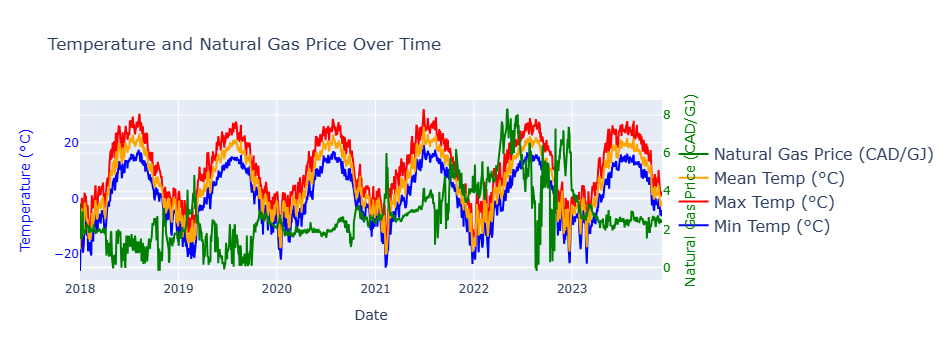

In [392]:
import plotly.graph_objects as go

fig = go.Figure()

# Add temperature data
fig.add_trace(go.Scatter(x=combined_avg_df.index, y=combined_avg_df['temperature_2m_min'], name='Min Temp (°C)', mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=combined_avg_df.index, y=combined_avg_df['temperature_2m_max'], name='Max Temp (°C)', mode='lines', line=dict(color='red')))
fig.add_trace(go.Scatter(x=combined_avg_df.index, y=combined_avg_df['temperature_2m_mean'], name='Mean Temp (°C)', mode='lines', line=dict(color='orange')))


# Add natural gas price data using a secondary y-axis
fig.add_trace(go.Scatter(x=combined_avg_df.index, y=combined_avg_df['aeco_5a_cad/gj'], name='Natural Gas Price (CAD/GJ)', mode='lines', line=dict(color='green'), yaxis='y2'))

# Update layout with secondary y-axis
fig.update_layout(
    title='Temperature and Natural Gas Price Over Time',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    yaxis=dict(
        title='Temperature (°C)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
    ),
    yaxis2=dict(
        title='Natural Gas Price (CAD/GJ)',
        titlefont=dict(color='green'),
        tickfont=dict(color='green'),
        overlaying='y',
        side='right'
    ),
    legend=dict(y=0.5, traceorder='reversed', font_size=16)
)

fig.show()

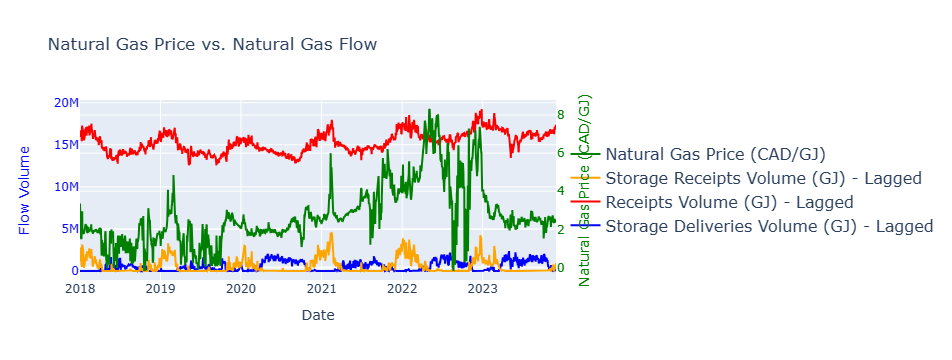

In [393]:
import plotly.graph_objects as go

fig = go.Figure()

# Add temperature data
fig.add_trace(go.Scatter(x=combined_avg_df.index, y=combined_avg_df['ngtl_storage_deliveries_volume_(103m3)_in_GJ_lag1'], name='Storage Deliveries Volume (GJ) - Lagged', mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=combined_avg_df.index, y=combined_avg_df['measured_receipts_volume_(103m3)_in_GJ_lag1'], name='Receipts Volume (GJ) - Lagged', mode='lines', line=dict(color='red')))
fig.add_trace(go.Scatter(x=combined_avg_df.index, y=combined_avg_df['ngtl_storage_receipts_volume_(103m3)_in_GJ_lag1'], name='Storage Receipts Volume (GJ) - Lagged', mode='lines', line=dict(color='orange')))


# Add natural gas price data using a secondary y-axis
fig.add_trace(go.Scatter(x=combined_avg_df.index, y=combined_avg_df['aeco_5a_cad/gj'], name='Natural Gas Price (CAD/GJ)', mode='lines', line=dict(color='green'), yaxis='y2'))

# Update layout with secondary y-axis
fig.update_layout(
    title='Natural Gas Price vs. Natural Gas Flow',
    xaxis_title='Date',
    yaxis_title='Natural Gas Flow',
    yaxis=dict(
        title='Flow Volume',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
    ),
    yaxis2=dict(
        title='Natural Gas Price (CAD/GJ)',
        titlefont=dict(color='green'),
        tickfont=dict(color='green'),
        overlaying='y',
        side='right'
    ),
    legend=dict(y=0.5, traceorder='reversed', font_size=16)
)

fig.show()

In [394]:
# Verifying the availability of these features in the ca_combined_df dataframe
available_columns = set(combined_avg_df.columns)
missing_weather_features = [feature for feature in features_weather if feature not in available_columns]
missing_ng_features = [feature for feature in features_ng if feature not in available_columns]
missing_target = target not in available_columns

missing_weather_features, missing_ng_features, missing_target

([], [], False)

In [638]:
# Separating out an entire year of data, year 2023 data, as a hold-out test set
#training_data = combined_avg_df[combined_avg_df.index.year < 2023].dropna()
#test_data_2023 = combined_avg_df[combined_avg_df.index.year == 2023].dropna()
training_data = combined_avg_df[(combined_avg_df.index < '2023-07-01')].dropna()
test_data_2023_second_half = combined_avg_df[(combined_avg_df.index >= '2023-07-01')].dropna()

# Display the shapes of each set to verify the separation
training_data.shape, test_data_2023_second_half.shape

((1431, 77), (109, 77))

In [525]:
features_weather = ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
       'apparent_temperature_max', 'apparent_temperature_min',
       'apparent_temperature_mean', 'daylight_duration', 'sunshine_duration',
       'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
       'wind_speed_10m_max', 'wind_gust_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotransporation', 'temp_min_1d_lag',
       'temp_max_1d_lag', 'temp_mean_1d_lag', 'temp_min_3d_lag',
       'temp_max_3d_lag', 'temp_mean_3d_lag', 'temp_min_7d_lag',
       'temp_max_7d_lag', 'temp_mean_7d_lag', 'sin_day_of_year',
       'cos_day_of_year', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12','season_Autumn',
       'season_Spring', 'season_Summer', 'season_Winter']

features_ng = ['electricity_daily_average',
       'electricity_daily_on_peak_average',
       'electricity_daily_off_peak_average', 'electricity_30ravg_average',
       'electricity_30ravg_on_peak_average',
       'electricity_30ravg__off_peak_average',
       'measured_receipts_volume_(103m3)_in_GJ_lag1',
       'ngtl_storage_receipts_volume_(103m3)_in_GJ_lag1',
       'ngtl_gordondale_receipts_volume_(103m3)_in_GJ_lag1',
       'ngtl_groundbirch_east_receipts_volume_(103m3)_in_GJ_lag1',
       'ngtl_intra_provincial_deliveries_volume_(103m3)_in_GJ_lag1',
       'ngtl_empress_deliveries_volume_(103m3)_in_GJ_lag1',
       'ngtl_abc_deliveries_volume_(103m3)_in_GJ_lag1',
       'ngtl_mcneil_deliveries_volume_(103m3)_in_GJ_lag1',
       'ngtl_gordondale_deliveries_volume_(103m3)_in_GJ_lag1',
       'ngtl_storage_deliveries_volume_(103m3)_in_GJ_lag1',
       'ngtl_border_deliveries_volume_(103m3)_in_GJ_lag1'
]

target = 'aeco_5a_cad/gj'

In [484]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.exceptions import ConvergenceWarning

### Weather only

In [575]:
# Preparing the features (X) and target (y)
X = training_data[features_weather]
y = training_data[target]

In [576]:
# Suppress convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Finding optimal lambda value
n_lambdas = 100
lambdas = np.logspace(-4, 2, n_lambdas) 
mses = []
coefs = []

for alpha in lambdas:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=alpha, fit_intercept=True, max_iter=10000))
    ])
    
    # Using TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=100)
    scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')
    
    scores = -scores
    mses.append(scores.mean())
    
    pipeline.fit(X, y)
    coefs.append(pipeline.named_steps['lasso'].coef_)

optimal_lambda_weather = lambdas[np.argmin(mses)]
print(f"Optimal Lambda for Lasso: {optimal_lambda_weather}")


Optimal Lambda for Lasso: 0.004977023564332114


In [577]:
# LASSO regression using the optimal lambda value
lasso_weather_model_optimal_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=optimal_lambda_weather, max_iter=10000))

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=100)

# Cross-validation using TimeSeriesSplit for both scoring metrics
lasso_cv_scores_weather = cross_val_score(lasso_weather_model_optimal_pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Evaluation
lasso_cv_scores_mean_weather = -lasso_cv_scores_weather.mean()
lasso_cv_scores_std_weather = lasso_cv_scores_weather.std()
lasso_rmse_weather = np.sqrt(lasso_cv_scores_mean_weather)

(lasso_cv_scores_mean_weather, lasso_cv_scores_std_weather, lasso_rmse_weather)

(2.622514793918002, 4.514990736644095, 1.6194180417415394)

In [578]:
# Fitting the LASSO model pipeline to the entire dataset
lasso_weather_model_optimal_pipeline.fit(X, y)

# Accessing the LASSO model within the pipeline and its coefficients
lasso_weather_coefficients = lasso_weather_model_optimal_pipeline.named_steps['lasso'].coef_

feature_names = X.columns
features_coefficients = zip(feature_names, lasso_weather_coefficients)

# Pair feature names with their coefficients into a dictionary for easy handling
lasso_weather_coefficients_dict = dict(zip(feature_names, lasso_weather_coefficients))

# Identify the coefficients that were reduced to 0
zero_coefficients = {feature: coef for feature, coef in lasso_weather_coefficients_dict.items() if abs(coef) < 1e-10}
zero_coefficients_weather = pd.DataFrame(list(zero_coefficients.items()), columns=['Feature', 'Coefficient'])

zero_coefficients_weather

,Feature,Coefficient
0,temperature_2m_max,-0.0
1,temperature_2m_min,-0.0
2,apparent_temperature_max,-0.0
3,apparent_temperature_min,0.0
4,apparent_temperature_mean,-0.0
5,daylight_duration,0.0
6,sunshine_duration,-0.0
7,rain_sum,0.0
8,snowfall_sum,0.0
9,wind_direction_10m_dominant,0.0


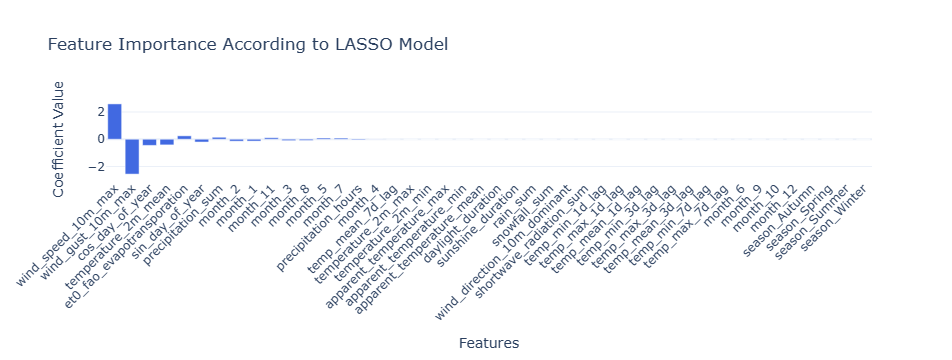

In [579]:
# Visualize coefficients
features_coefficients = zip(feature_names, lasso_weather_coefficients)

# Convert to list for sorting and plotting
features_coefficients_list = list(features_coefficients)

# Sort coefficients by their absolute values for better visualization
features_coefficients_list.sort(key=lambda x: abs(x[1]), reverse=True)

# Unzip into two lists for plotting
sorted_features, sorted_coefficients = zip(*features_coefficients_list)

# Create a bar chart
fig = go.Figure([go.Bar(x=sorted_features, y=sorted_coefficients, marker_color='royalblue')])
fig.update_layout(
    title='Feature Importance According to LASSO Model',
    xaxis_title='Features',
    yaxis_title='Coefficient Value',
    xaxis_tickangle=-45,
    template='plotly_white'
)

fig.show()


In [580]:
# Rolling Window Approach
window_size = 60

# Store predictions and actual values
predictions = []
actuals = []

lasso_weather_model_optimal_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=optimal_lambda_weather, max_iter=10000))

# Loop over the test set, using a rolling window approach
for i in range(window_size, len(test_data_2023_second_half)):
    # Define the rolling window
    train_rolling = training_data.iloc[-window_size+i-len(test_data_2023_second_half):i-len(test_data_2023_second_half)]
    test_point = test_data_2023_second_half.iloc[i-window_size:i-window_size+1]
    
    # Prepare the features and target
    X_train_rolling = train_rolling[features_weather] 
    y_train_rolling = train_rolling[target]
    X_test_point = test_point[features_weather]
    
    # Fit the model on the rolling window
    lasso_weather_model_optimal_pipeline.fit(X_train_rolling, y_train_rolling)
    
    # Make a prediction for the next point
    prediction = lasso_weather_model_optimal_pipeline.predict(X_test_point)
    
    # Store the prediction and the actual value
    predictions.append(prediction[0])
    actuals.append(test_point[target].values[0])

# Calculate evaluation metrics
mse_weather = mean_squared_error(actuals, predictions)
rmse_weather = np.sqrt(mse_weather)

print(f"MSE: {mse_weather}, RMSE: {rmse_weather}")


MSE: 1.1481423136101803, RMSE: 1.0715140286576654


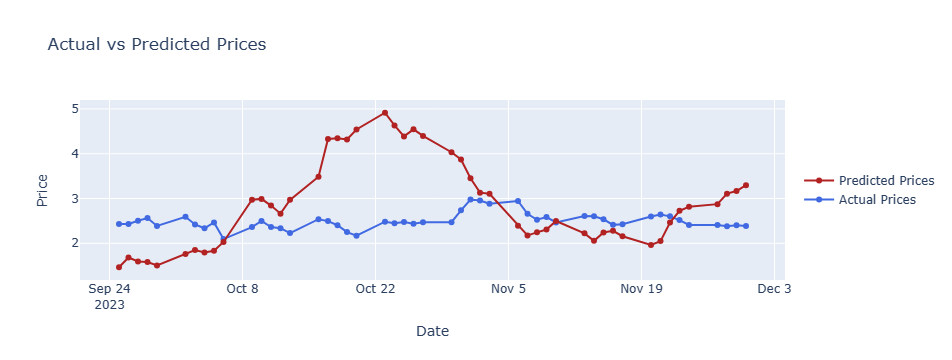

In [582]:
# Plotting
dates_for_plotting = test_data_2023_second_half.index[window_size:]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates_for_plotting, y=actuals,
                         mode='lines+markers',
                         name='Actual Prices',
                         line=dict(color='royalblue')))
fig.add_trace(go.Scatter(x=dates_for_plotting, y=predictions,
                         mode='lines+markers',
                         name='Predicted Prices',
                         line=dict(color='firebrick')))
fig.update_layout(title='Actual vs Predicted Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(y=0.5, traceorder='reversed', font_size=12))

fig.show()

### NGTL

In [583]:
# Preparing the features (X) and target (y)
X = training_data[features_ng]
y = training_data[target]

In [584]:
# Suppress convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Finding optimal lambda value

n_lambdas = 100
lambdas = np.logspace(-4, 2, n_lambdas) 
mses = []
coefs = []

for alpha in lambdas:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=alpha, fit_intercept=True, max_iter=10000))
    ])
    
    # Using TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=100)
    scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')
    
    scores = -scores
    mses.append(scores.mean())
    
    pipeline.fit(X, y)
    coefs.append(pipeline.named_steps['lasso'].coef_)

optimal_lambda_ng = lambdas[np.argmin(mses)]
print(f"Optimal Lambda for Lasso: {optimal_lambda_ng}")

Optimal Lambda for Lasso: 0.07054802310718646


In [585]:
# LASSO regression using the optimal lambda value
lasso_ng_model_optimal_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=optimal_lambda_ng, max_iter=10000))

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=100)

# Cross-validation using TimeSeriesSplit for both scoring metrics
lasso_cv_scores_ng = cross_val_score(lasso_ng_model_optimal_pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Evaluation
lasso_cv_scores_mean_ng = -lasso_cv_scores_ng.mean()
lasso_cv_scores_std_ng = lasso_cv_scores_ng.std()
lasso_rmse_ng = np.sqrt(lasso_cv_scores_mean_ng)

(lasso_cv_scores_mean_ng, lasso_cv_scores_std_ng, lasso_rmse_ng)

(1.6767094705183734, 2.797362024384234, 1.2948781682144361)

In [586]:
# Fitting the LASSO model pipeline to the entire dataset
lasso_ng_model_optimal_pipeline.fit(X, y)

# Accessing the LASSO model within the pipeline and its coefficients
lasso_ng_coefficients = lasso_ng_model_optimal_pipeline.named_steps['lasso'].coef_

feature_names = X.columns
features_coefficients = zip(feature_names, lasso_ng_coefficients)

# Pair feature names with their coefficients into a dictionary for easy handling
lasso_ng_coefficients_dict = dict(zip(feature_names, lasso_ng_coefficients))

# Identify the coefficients that were reduced to 0
zero_coefficients = {feature: coef for feature, coef in lasso_ng_coefficients_dict.items() if abs(coef) < 1e-10}
zero_coefficients_ng = pd.DataFrame(list(zero_coefficients.items()), columns=['Feature', 'Coefficient'])

zero_coefficients_ng

,Feature,Coefficient
0,electricity_daily_average,0.0
1,electricity_daily_on_peak_average,0.0
2,electricity_30ravg_average,0.0
3,electricity_30ravg_on_peak_average,-0.0
4,ngtl_storage_receipts_volume_(103m3)_in_GJ_lag1,0.0
5,ngtl_intra_provincial_deliveries_volume_(103m3...,0.0
6,ngtl_abc_deliveries_volume_(103m3)_in_GJ_lag1,0.0
7,ngtl_gordondale_deliveries_volume_(103m3)_in_G...,-0.0
8,ngtl_border_deliveries_volume_(103m3)_in_GJ_lag1,0.0


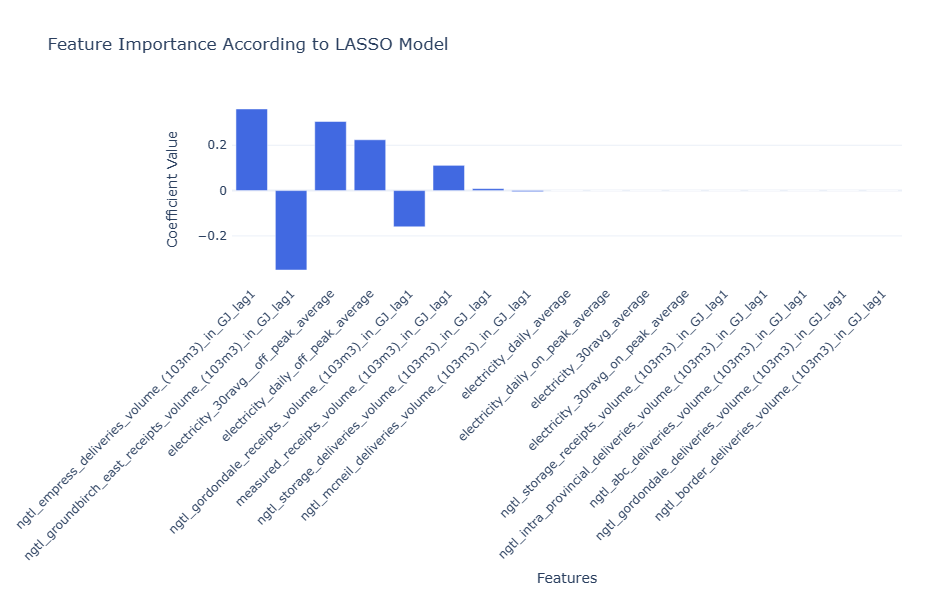

In [587]:
# Visualize coefficients
features_coefficients = zip(feature_names, lasso_ng_coefficients)

# Convert to list for sorting and plotting
features_coefficients_list = list(features_coefficients)

# Sort coefficients by their absolute values for better visualization
features_coefficients_list.sort(key=lambda x: abs(x[1]), reverse=True)

# Unzip into two lists for plotting
sorted_features, sorted_coefficients = zip(*features_coefficients_list)

# Create a bar chart
fig = go.Figure([go.Bar(x=sorted_features, y=sorted_coefficients, marker_color='royalblue')])
fig.update_layout(
    title='Feature Importance According to LASSO Model',
    xaxis_title='Features',
    yaxis_title='Coefficient Value',
    xaxis_tickangle=-45,
    template='plotly_white',
    autosize=False,
    width=1000, 
    height=600,  
    margin=dict(
        l=100, 
        r=50, 
        b=150,  
        t=100,
        pad=4
    )
)

fig.show()

In [588]:
# Rolling Window Approach
window_size = 60

# Store predictions and actual values
predictions = []
actuals = []


# Create the LASSO model pipeline with the optimal lambda
lasso_ng_model_optimal_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=optimal_lambda_ng, max_iter=10000))

# Loop over the test set, using a rolling window approach
for i in range(window_size, len(test_data_2023_second_half)):
    # Define the rolling window
    train_rolling = training_data.iloc[-window_size+i-len(test_data_2023_second_half):i-len(test_data_2023_second_half)]
    test_point = test_data_2023_second_half.iloc[i-window_size:i-window_size+1]
    
    # Prepare the features and target
    X_train_rolling = train_rolling[features_ng] 
    y_train_rolling = train_rolling[target]
    X_test_point = test_point[features_ng]
    
    # Fit the model on the rolling window
    lasso_ng_model_optimal_pipeline.fit(X_train_rolling, y_train_rolling)
    
    # Make a prediction for the next point
    prediction = lasso_ng_model_optimal_pipeline.predict(X_test_point)
    
    # Store the prediction and the actual value
    predictions.append(prediction[0])
    actuals.append(test_point[target].values[0])

# Calculate evaluation metrics
mse_ng = mean_squared_error(actuals, predictions)
rmse_ng = np.sqrt(mse_ng)

print(f"MSE: {mse_ng}, RMSE: {rmse_ng}")


MSE: 0.06469662515141356, RMSE: 0.25435531280359286


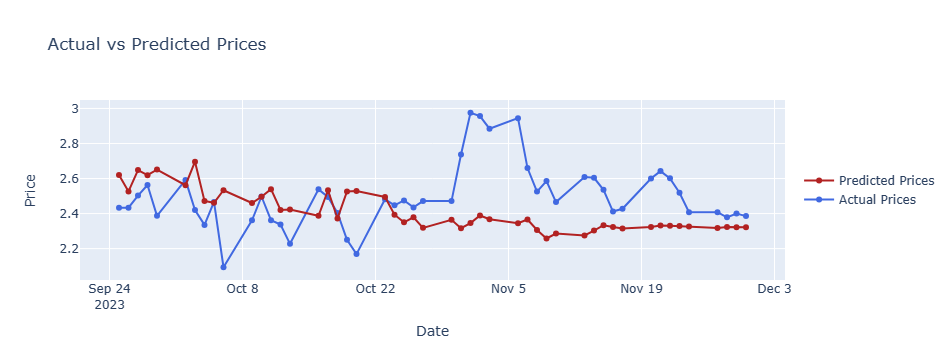

In [589]:
# Plotting
dates_for_plotting = test_data_2023_second_half.index[window_size:]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates_for_plotting, y=actuals,
                         mode='lines+markers',
                         name='Actual Prices',
                         line=dict(color='royalblue')))
fig.add_trace(go.Scatter(x=dates_for_plotting, y=predictions,
                         mode='lines+markers',
                         name='Predicted Prices',
                         line=dict(color='firebrick')))
fig.update_layout(title='Actual vs Predicted Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(y=0.5, traceorder='reversed', font_size=12))

fig.show()

### Combined

In [590]:
# Preparing the features (X) and target (y)
X = training_data[features_weather + features_ng]
y = training_data[target]

In [591]:
# Suppress convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Finding optimal lambda value

n_lambdas = 100
lambdas = np.logspace(-4, 2, n_lambdas) 
mses = []
coefs = []

for alpha in lambdas:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=alpha, fit_intercept=True, max_iter=10000))
    ])
    
    # Using TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=100)
    scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')
    
    scores = -scores
    mses.append(scores.mean())
    
    pipeline.fit(X, y)
    coefs.append(pipeline.named_steps['lasso'].coef_)

optimal_lambda_combined = lambdas[np.argmin(mses)]
print(f"Optimal Lambda for Lasso: {optimal_lambda_combined}")


Optimal Lambda for Lasso: 0.093260334688322


In [592]:
# LASSO regression using the optimal lambda value
lasso_model_optimal_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=optimal_lambda_combined, max_iter=10000))

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=100)

# Cross-validation using TimeSeriesSplit for both scoring metrics
lasso_cv_scores_combined = cross_val_score(lasso_model_optimal_pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Evaluation
lasso_cv_scores_mean_combined = -lasso_cv_scores_combined.mean()
lasso_cv_scores_std_combined = lasso_cv_scores_combined.std()
lasso_rmse_combined = np.sqrt(lasso_cv_scores_mean_combined)

(lasso_cv_scores_mean_combined, lasso_cv_scores_std_combined, lasso_rmse_combined)


(1.6995842741827598, 2.748013250737524, 1.3036810477194027)

In [593]:
# Fitting the LASSO model pipeline to the entire dataset
lasso_model_optimal_pipeline.fit(X, y)

# Accessing the LASSO model within the pipeline and its coefficients
lasso_combined_coefficients = lasso_model_optimal_pipeline.named_steps['lasso'].coef_

feature_names = X.columns
features_coefficients = zip(feature_names, lasso_combined_coefficients)

# Pair feature names with their coefficients into a dictionary for easy handling
lasso_combined_coefficients_dict = dict(zip(feature_names, lasso_combined_coefficients))

# Identify the coefficients that were reduced to 0
zero_coefficients = {feature: coef for feature, coef in lasso_combined_coefficients_dict.items() if abs(coef) < 1e-10}
zero_coefficients_combined = pd.DataFrame(list(zero_coefficients.items()), columns=['Feature', 'Coefficient'])

zero_coefficients_combined

,Feature,Coefficient
0,temperature_2m_max,0.0
1,temperature_2m_min,0.0
2,temperature_2m_mean,0.0
3,apparent_temperature_max,0.0
4,apparent_temperature_min,0.0
5,apparent_temperature_mean,0.0
6,daylight_duration,0.0
7,sunshine_duration,0.0
8,precipitation_sum,0.0
9,snowfall_sum,0.0


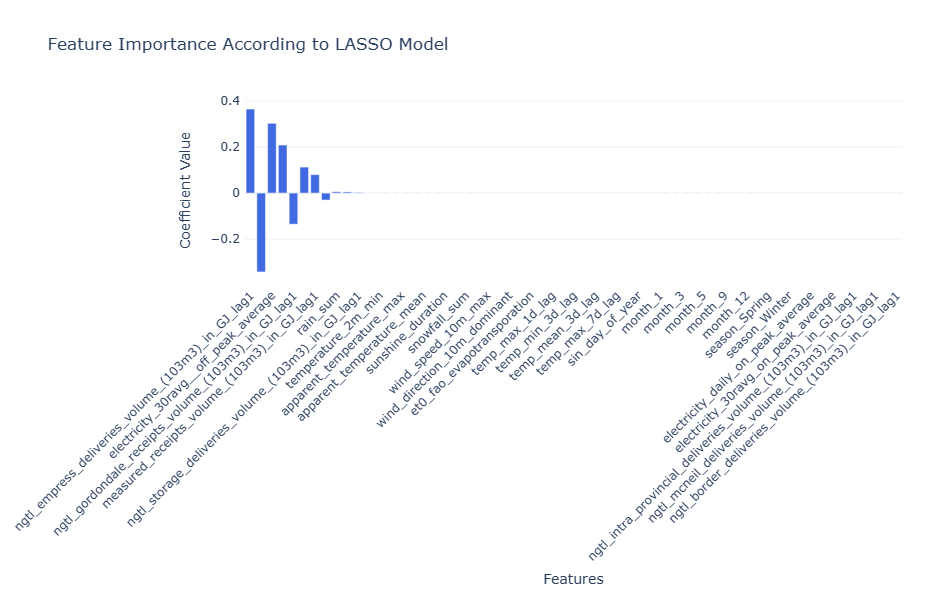

In [594]:
# Visualize coefficients
features_coefficients = zip(feature_names, lasso_combined_coefficients)

# Convert to list for sorting and plotting
features_coefficients_list = list(features_coefficients)

# Sort coefficients by their absolute values for better visualization
features_coefficients_list.sort(key=lambda x: abs(x[1]), reverse=True)

# Unzip into two lists for plotting
sorted_features, sorted_coefficients = zip(*features_coefficients_list)

# Create a bar chart
fig = go.Figure([go.Bar(x=sorted_features, y=sorted_coefficients, marker_color='royalblue')])
fig.update_layout(
    title='Feature Importance According to LASSO Model',
    xaxis_title='Features',
    yaxis_title='Coefficient Value',
    xaxis_tickangle=-45,
    template='plotly_white',
    autosize=False,
    width=1000, 
    height=600,  
    margin=dict(
        l=100, 
        r=50, 
        b=150,  
        t=100,
        pad=4
    )
)

fig.show()

In [595]:
# Rolling Window Approach
window_size = 60

# Store predictions and actual values
predictions = []
actuals = []

# Create the LASSO model pipeline with the optimal lambda
lasso_model_optimal_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=optimal_lambda_combined, max_iter=10000))

# Loop over the test set, using a rolling window approach
for i in range(window_size, len(test_data_2023_second_half)):
    # Define the rolling window
    train_rolling = training_data.iloc[-window_size+i-len(test_data_2023_second_half):i-len(test_data_2023_second_half)]
    test_point = test_data_2023_second_half.iloc[i-window_size:i-window_size+1]
    
    # Prepare the features and target
    X_train_rolling = train_rolling[features_weather + features_ng] 
    y_train_rolling = train_rolling[target]
    X_test_point = test_point[features_weather + features_ng]
    
    # Fit the model on the rolling window
    lasso_model_optimal_pipeline.fit(X_train_rolling, y_train_rolling)
    
    # Make a prediction for the next point
    prediction = lasso_model_optimal_pipeline.predict(X_test_point)
    
    # Store the prediction and the actual value
    predictions.append(prediction[0])
    actuals.append(test_point[target].values[0])

# Calculate evaluation metrics
mse_combined = mean_squared_error(actuals, predictions)
rmse_combined = np.sqrt(mse_combined)

print(f"MSE: {mse_combined}, RMSE: {rmse_combined}")


MSE: 0.08154737693482969, RMSE: 0.285565013499255


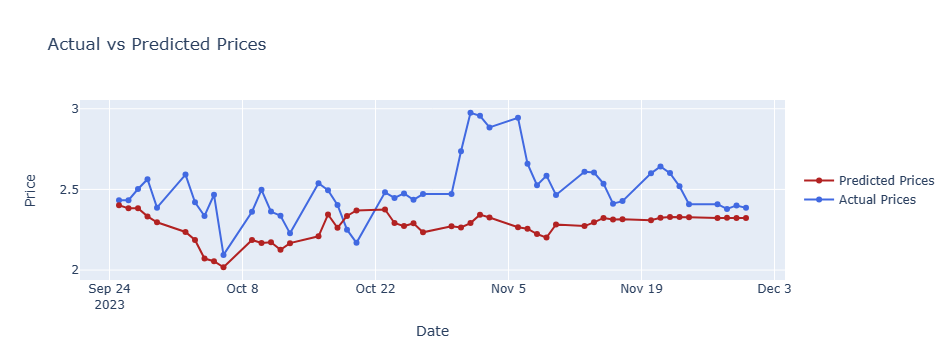

In [596]:
# Plotting
dates_for_plotting = test_data_2023_second_half.index[window_size:]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates_for_plotting, y=actuals,
                         mode='lines+markers',
                         name='Actual Prices',
                         line=dict(color='royalblue')))
fig.add_trace(go.Scatter(x=dates_for_plotting, y=predictions,
                         mode='lines+markers',
                         name='Predicted Prices',
                         line=dict(color='firebrick')))

fig.update_layout(title='Actual vs Predicted Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(y=0.5, traceorder='reversed', font_size=12))

fig.show()

### Model Comparison

In [618]:
# Creating a dataframe to compare the models' performance
model_comparison_df = pd.DataFrame({
    'LASSO Model': ['Weather Features Only', 'Electricity & NG Features', 'Combined Features'],
    'Average Mean Sqaured Error': [lasso_cv_scores_mean_weather, lasso_cv_scores_mean_ng, lasso_cv_scores_mean_combined],
    'Average Root Mean Sqaured Error': [lasso_rmse_weather, lasso_rmse_ng, lasso_rmse_combined]
})

model_comparison_df

,LASSO Model,Average Mean Sqaured Error,Average Root Mean Sqaured Error
0,Weather Features Only,2.622515,1.619418
1,Electricity & NG Features,1.676709,1.294878
2,Combined Features,1.699584,1.303681


In [619]:
# Creating a dataframe to compare the models' performance
model_comparison_df2 = pd.DataFrame({
    'LASSO Rolling Window Model': ['Weather Features Only', 'Electricity & NG Features', 'Combined Features'],
    'Average Mean Sqaured Error': [mse_weather, mse_ng, mse_combined],
    'Average Root Mean Sqaured Error': [rmse_weather, rmse_ng, rmse_combined]
})

model_comparison_df2

,LASSO Rolling Window Model,Average Mean Sqaured Error,Average Root Mean Sqaured Error
0,Weather Features Only,1.148142,1.071514
1,Electricity & NG Features,0.064697,0.254355
2,Combined Features,0.081547,0.285565


### Post Lasso Ridge

In [597]:
# Identify non-zero coefficients (features not dropped by Lasso)
non_zero_coefficients = {feature: coef for feature, coef in lasso_combined_coefficients_dict.items() if abs(coef) >= 1e-10}

# Print features not reduced to zero by Lasso
print("Features retained by Lasso:")
for feature in non_zero_coefficients.keys():
    print(feature)

# Filter the original dataset to keep only features with non-zero coefficients
X_filtered = X[list(non_zero_coefficients.keys())]

Features retained by Lasso:
rain_sum
month_7
month_8
month_11
electricity_daily_off_peak_average
electricity_30ravg__off_peak_average
measured_receipts_volume_(103m3)_in_GJ_lag1
ngtl_gordondale_receipts_volume_(103m3)_in_GJ_lag1
ngtl_groundbirch_east_receipts_volume_(103m3)_in_GJ_lag1
ngtl_empress_deliveries_volume_(103m3)_in_GJ_lag1
ngtl_storage_deliveries_volume_(103m3)_in_GJ_lag1


In [600]:
features_new = ['rain_sum',
'month_7',
'month_8',
'month_11',
'electricity_daily_off_peak_average',
'electricity_30ravg__off_peak_average',
'measured_receipts_volume_(103m3)_in_GJ_lag1',
'ngtl_gordondale_receipts_volume_(103m3)_in_GJ_lag1',
'ngtl_groundbirch_east_receipts_volume_(103m3)_in_GJ_lag1',
'ngtl_empress_deliveries_volume_(103m3)_in_GJ_lag1',
'ngtl_storage_deliveries_volume_(103m3)_in_GJ_lag1']

In [601]:
X = training_data[features_new]
y = training_data[target]

In [602]:
# Finding optimal lambda value again
n_lambdas = 600
lambdas = np.linspace(0, 1000, n_lambdas)
mses = []
coefs = []

for alpha in lambdas:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha, fit_intercept=True))
    ])
    
    tscv = TimeSeriesSplit(n_splits=100)
    scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')
    
    scores = -scores
    mses.append(scores.mean())
    
    pipeline.fit(X, y)
    coefs.append(pipeline.named_steps['ridge'].coef_)

optimal_lambda_ridge = lambdas[np.argmin(mses)]

optimal_lambda_ridge


579.2988313856428

In [607]:
# Ridge regression using optimal lambda value
ridge_model_optimal_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=optimal_lambda_ridge))

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=100)

# Cross-validation using TimeSeriesSplit for both scoring metrics
ridge_cv_scores = cross_val_score(ridge_model_optimal_pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Evaluation
ridge_cv_scores_mean = -ridge_cv_scores.mean() 
ridge_cv_scores_std = ridge_cv_scores.std()
ridge_rmse = np.sqrt(ridge_cv_scores_mean)

(ridge_cv_scores_mean, ridge_cv_scores_std, ridge_rmse)


(1.4721974213698246, 2.001041657386276, 1.213341428193163)

In [608]:
# Define the window size
window_size = 60 

# Initialize lists to store predictions and actual values
predictions = []
actuals = []

# Loop over the test set, using a rolling window approach
for i in range(window_size, len(test_data_2023_second_half)):
    # Define the rolling window
    train_rolling = training_data.iloc[-window_size+i-len(test_data_2023_second_half):i-len(test_data_2023_second_half)]
    test_point = test_data_2023_second_half.iloc[i-window_size:i-window_size+1]
    
    # Prepare the features and target
    X_train_rolling = train_rolling[features_new]
    y_train_rolling = train_rolling[target]
    X_test_point = test_point[features_new]
    
    # Fit the model
    ridge_model_optimal_pipeline.fit(X_train_rolling, y_train_rolling)
    
    # Make a prediction for the next point
    prediction = ridge_model_optimal_pipeline.predict(X_test_point)
    
    # Store the prediction and actual value
    predictions.append(prediction[0])
    actuals.append(test_point[target].values[0])

# Calculate evaluation metrics
mse_ridge = mean_squared_error(actuals, predictions)
rmse_ridge = np.sqrt(mse_ridge)
print(f"MSE: {mse_ridge}, RMSE: {rmse_ridge}")


MSE: 0.060032748218027523, RMSE: 0.24501581217959695


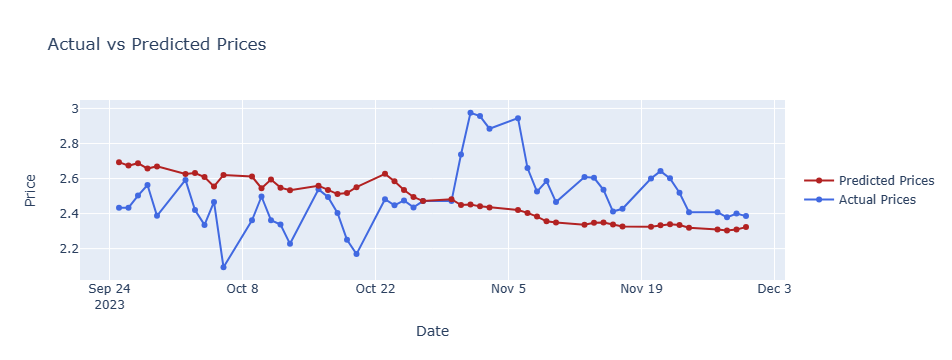

In [609]:
# Ensure the length of the datetime index matches the length of your predictions and actuals
dates_for_plotting = test_data_2023_second_half.index[window_size:]

# Create a Plotly figure
fig = go.Figure()

# Add actual prices to the plot
fig.add_trace(go.Scatter(x=dates_for_plotting, y=actuals,
                         mode='lines+markers',
                         name='Actual Prices',
                         line=dict(color='royalblue')))

# Add predicted prices to the plot
fig.add_trace(go.Scatter(x=dates_for_plotting, y=predictions,
                         mode='lines+markers',
                         name='Predicted Prices',
                         line=dict(color='firebrick')))

# Update layout
fig.update_layout(title='Actual vs Predicted Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(y=0.5, traceorder='reversed', font_size=12))

# Show the figure
fig.show()


### Post Lasso Linear

In [610]:
# Preparing the features (X) and target (y)
X = training_data[features_new]
y = training_data[target]

In [611]:
# Linear Regression model pipeline
linear_model_pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=100)

# Cross-validation using TimeSeriesSplit for both scoring metrics
linear_cv_scores = cross_val_score(linear_model_pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Evaluation
linear_cv_scores_mean = -linear_cv_scores.mean()
linear_cv_scores_std = linear_cv_scores.std()
linear_rmse = np.sqrt(linear_cv_scores_mean)

(linear_cv_scores_mean, linear_cv_scores_std, linear_rmse)


(1.6257612586751224, 2.7995337935572135, 1.275053433654889)

In [612]:
# Define the window size
window_size = 60 

# Initialize lists to store predictions and actual values
predictions = []
actuals = []

# Loop over the test set, using a rolling window approach
for i in range(window_size, len(test_data_2023_second_half)):
    # Define the rolling window
    train_rolling = training_data.iloc[-window_size+i-len(test_data_2023_second_half):i-len(test_data_2023_second_half)]
    test_point = test_data_2023_second_half.iloc[i-window_size:i-window_size+1]
    
    # Prepare the features and target
    X_train_rolling = train_rolling[features_new]
    y_train_rolling = train_rolling[target]
    X_test_point = test_point[features_new]
    
    # Fit the model
    linear_model_pipeline.fit(X_train_rolling, y_train_rolling)
    
    # Make a prediction for the next point
    prediction = linear_model_pipeline.predict(X_test_point)
    
    # Store the prediction and actual value
    predictions.append(prediction[0])
    actuals.append(test_point[target].values[0])

# Calculate evaluation metrics
mse_lr = mean_squared_error(actuals, predictions)
rmse_lr = np.sqrt(mse_lr)
print(f"MSE: {mse_lr}, RMSE: {rmse_lr}")


MSE: 0.08067349172238251, RMSE: 0.2840307936164361


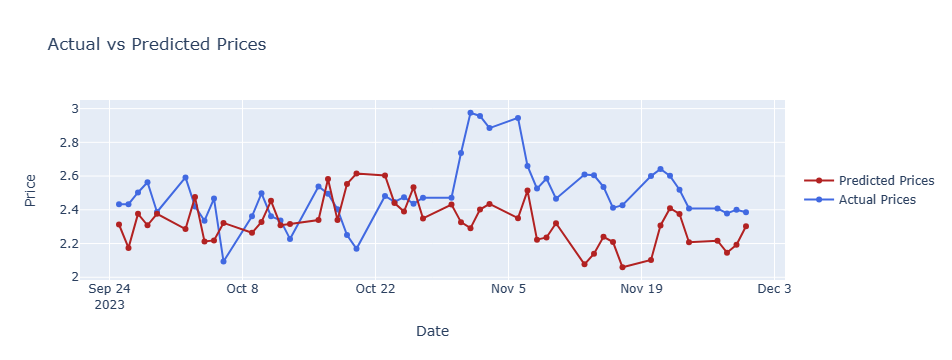

In [613]:
# Ensure the length of the datetime index matches the length of your predictions and actuals
dates_for_plotting = test_data_2023_second_half.index[window_size:]

# Create a Plotly figure
fig = go.Figure()

# Add actual prices to the plot
fig.add_trace(go.Scatter(x=dates_for_plotting, y=actuals,
                         mode='lines+markers',
                         name='Actual Prices',
                         line=dict(color='royalblue')))

# Add predicted prices to the plot
fig.add_trace(go.Scatter(x=dates_for_plotting, y=predictions,
                         mode='lines+markers',
                         name='Predicted Prices',
                         line=dict(color='firebrick')))

# Update layout
fig.update_layout(title='Actual vs Predicted Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(y=0.5, traceorder='reversed', font_size=12))

# Show the figure
fig.show()

In [617]:
# Creating a dataframe to compare the models' performance
model_comparison_df3 = pd.DataFrame({
    'Rolling Window Models': ['LASSO (Combined Features)', 'Ridge', 'Linear Regression'],
    'Average Mean Sqaured Error': [mse_combined, mse_ridge, mse_lr],
    'Average Root Mean Sqaured Error': [rmse_combined, rmse_ridge, rmse_lr]
})

model_comparison_df3

,Rolling Window Models,Average Mean Sqaured Error,Average Root Mean Sqaured Error
0,LASSO (Combined Features),0.081547,0.285565
1,Ridge,0.060033,0.245016
2,Linear Regression,0.080673,0.284031


### SARIMAX

Mean Squared Error: 0.04844260572516724, Root Mean Squared Error: 0.22009680989320868


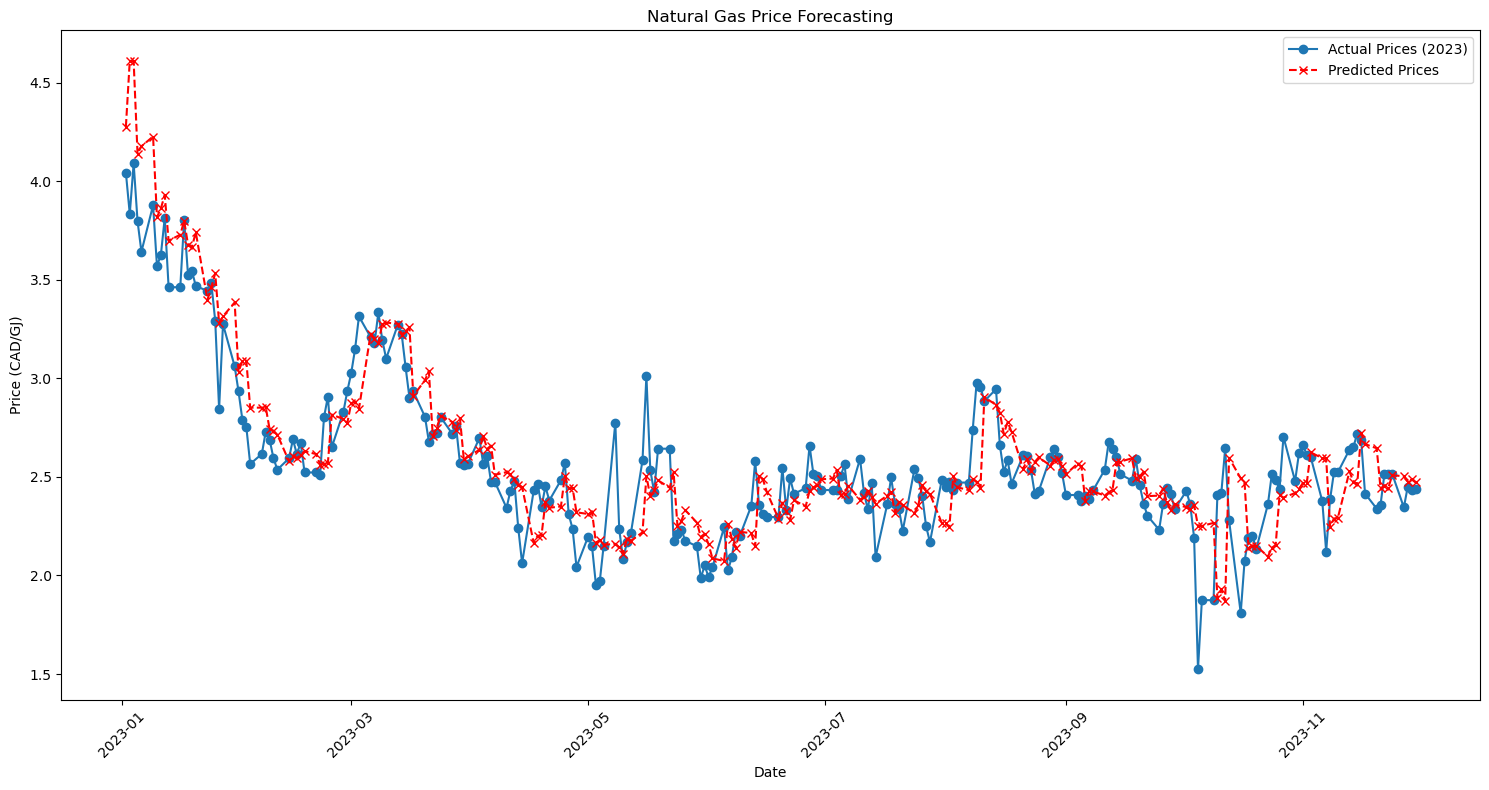

Chosen order (p, d, q): (2, 1, 4)
Chosen seasonal order (P, D, Q, m): (0, 0, 0, 0)


In [616]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define window size
window_size = 3

# Extract training and testing data
#training_data = combined_avg_df[(combined_avg_df.index < '2023-07-01')].dropna()
#test_data_2023_second_half = combined_avg_df[(combined_avg_df.index >= '2023-07-01')].dropna()
train_data = combined_avg_df['2018-01-01':'2022-12-31']['aeco_5a_cad/gj']
test_data_2023 = combined_avg_df['2023-01-01':]['aeco_5a_cad/gj']

# Train the SARIMA model on the training data
model = pm.auto_arima(train_data, seasonal=True, stepwise=True, suppress_warnings=True, error_action='ignore')

# Initialize lists for predictions and actual values
predictions = []
actual_values_2023 = []

# Rolling Window Forecasting
for i in range(0, len(test_data_2023), window_size):
    # Define the current window's test data
    if i + window_size < len(test_data_2023):
        current_window_data = test_data_2023.iloc[i:i + window_size]
    else:
        current_window_data = test_data_2023.iloc[i:]
    
    # Forecast for the window size or remaining data points
    forecast = model.predict(n_periods=len(current_window_data))
    
    # Update the model with the current window's data
    model.update(current_window_data)
    
    # Extend the lists with the forecasts and actual values
    predictions.extend(forecast)
    actual_values_2023.extend(current_window_data.values)

# Calculate and print the Mean Squared Error
mse_arima = mean_squared_error(actual_values_2023, predictions)
rmse_arima = np.sqrt(mse_arima)
print(f'Mean Squared Error: {mse_arima}, Root Mean Squared Error: {rmse_arima}')

# Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(test_data_2023.index, actual_values_2023, label='Actual Prices (2023)', marker='o')
plt.plot(test_data_2023.index, predictions, label='Predicted Prices', color='red', linestyle='--', marker='x')
plt.legend()
plt.title('Natural Gas Price Forecasting')
plt.ylabel('Price (CAD/GJ)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the chosen order and seasonal order of the model
print("Chosen order (p, d, q):", model.order)
print("Chosen seasonal order (P, D, Q, m):", model.seasonal_order)


### Creating Price Lags into LASSO

In [620]:
for lag in [1, 2, 3, 4]:
    combined_avg_df[f'lag_{lag}'] = combined_avg_df['aeco_5a_cad/gj'].shift(lag)

training_data = combined_avg_df[(combined_avg_df.index < '2023-07-01')].dropna()
test_data_2023_second_half = combined_avg_df[(combined_avg_df.index >= '2023-07-01')].dropna()

# Display the shapes of each set to verify the separation
training_data.shape, test_data_2023_second_half.shape


((1431, 77), (109, 77))

In [621]:
features_lags = ['lag_1', 'lag_2', 'lag_3', 'lag_4']

In [622]:
# Preparing the features (X) and target (y)
X = training_data[features_weather + features_ng + features_lags]
y = training_data[target]

In [623]:
# Finding optimal lambda value
n_lambdas = 100
lambdas = np.logspace(-4, 2, n_lambdas) 
mses = []
coefs = []

for alpha in lambdas:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=alpha, fit_intercept=True, max_iter=10000))
    ])
    
    # Using TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=100)
    scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')
    
    scores = -scores
    mses.append(scores.mean())
    
    pipeline.fit(X, y)
    coefs.append(pipeline.named_steps['lasso'].coef_)

new_optimal_lambda = lambdas[np.argmin(mses)]
print(f"New Optimal Lambda for Lasso: {new_optimal_lambda}")


New Optimal Lambda for Lasso: 0.03511191734215131


In [624]:
# LASSO regression using the optimal lambda value
new_lasso_model_optimal_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=new_optimal_lambda, max_iter=10000))

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=100)

# Cross-validation using TimeSeriesSplit for both scoring metrics
new_lasso_cv_scores = cross_val_score(new_lasso_model_optimal_pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Evaluation
new_lasso_cv_scores_mean = -new_lasso_cv_scores.mean()
new_lasso_cv_scores_std = new_lasso_cv_scores.std()
new_lasso_rmse = np.sqrt(new_lasso_cv_scores_mean)

(new_lasso_cv_scores_mean, new_lasso_cv_scores_std, new_lasso_rmse)

(0.2513483621135808, 0.5205281604662139, 0.501346548919588)

In [625]:
# Fitting the LASSO model pipeline to the entire dataset
new_lasso_model_optimal_pipeline.fit(X, y)

# Accessing the LASSO model within the pipeline and its coefficients
new_lasso_combined_coefficients = new_lasso_model_optimal_pipeline.named_steps['lasso'].coef_

feature_names = X.columns
features_coefficients = zip(feature_names, new_lasso_combined_coefficients)

# Pair feature names with their coefficients into a dictionary for easy handling
new_lasso_combined_coefficients_dict = dict(zip(feature_names, new_lasso_combined_coefficients))

# Identify the coefficients that were reduced to 0
zero_coefficients = {feature: coef for feature, coef in new_lasso_combined_coefficients_dict.items() if abs(coef) < 1e-10}
new_zero_coefficients_combined = pd.DataFrame(list(zero_coefficients.items()), columns=['Feature', 'Coefficient'])

new_zero_coefficients_combined

,Feature,Coefficient
0,temperature_2m_max,-0.0
1,temperature_2m_min,-0.0
2,temperature_2m_mean,-0.0
3,apparent_temperature_max,-0.0
4,apparent_temperature_min,-0.0
5,apparent_temperature_mean,-0.0
6,daylight_duration,-0.0
7,sunshine_duration,-0.0
8,precipitation_sum,0.0
9,rain_sum,-0.0


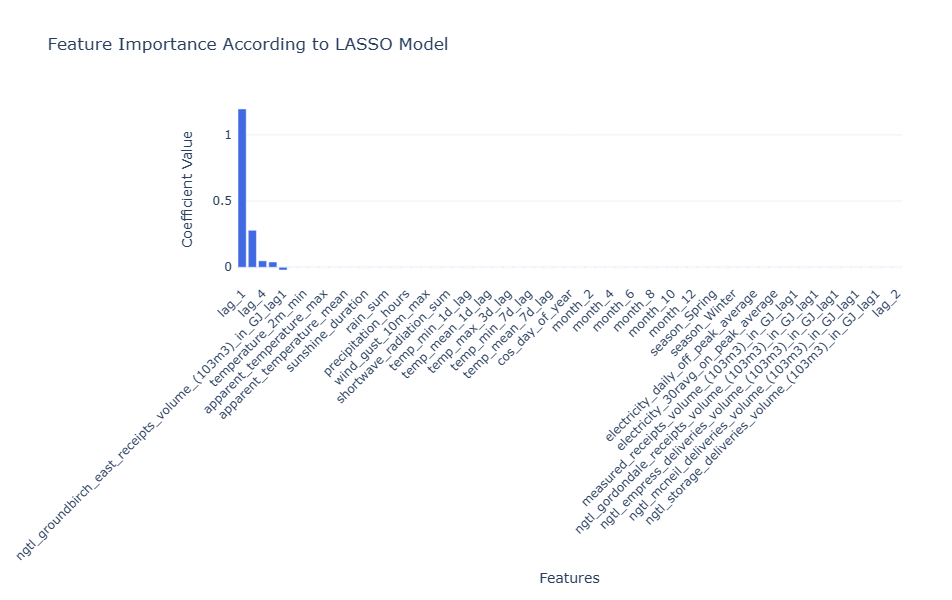

In [626]:
# Visualize coefficients
features_coefficients = zip(feature_names, new_lasso_combined_coefficients)

# Convert to list for sorting and plotting
features_coefficients_list = list(features_coefficients)

# Sort coefficients by their absolute values for better visualization
features_coefficients_list.sort(key=lambda x: abs(x[1]), reverse=True)

# Unzip into two lists for plotting
sorted_features, sorted_coefficients = zip(*features_coefficients_list)

# Create a bar chart
fig = go.Figure([go.Bar(x=sorted_features, y=sorted_coefficients, marker_color='royalblue')])
fig.update_layout(
    title='Feature Importance According to LASSO Model',
    xaxis_title='Features',
    yaxis_title='Coefficient Value',
    xaxis_tickangle=-45,
    template='plotly_white',
    autosize=False,
    width=1000, 
    height=600,  
    margin=dict(
        l=100, 
        r=50, 
        b=150,  
        t=100,
        pad=4
    )
)

fig.show()

In [628]:
# Rolling Window Approach
window_size = 60

# Store predictions and actual values
predictions = []
actuals = []

# Create the LASSO model pipeline with the optimal lambda
new_lasso_model_optimal_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=new_optimal_lambda, max_iter=10000))

# Loop over the test set, using a rolling window approach
for i in range(window_size, len(test_data_2023_second_half)):
    # Define the rolling window
    train_rolling = training_data.iloc[-window_size+i-len(test_data_2023_second_half):i-len(test_data_2023_second_half)]
    test_point = test_data_2023_second_half.iloc[i-window_size:i-window_size+1]
    
    # Prepare the features and target
    X_train_rolling = train_rolling[features_weather + features_ng + features_lags] 
    y_train_rolling = train_rolling[target]
    X_test_point = test_point[features_weather + features_ng + features_lags]
    
    # Fit the model on the rolling window
    new_lasso_model_optimal_pipeline.fit(X_train_rolling, y_train_rolling)
    
    # Make a prediction for the next point
    prediction = new_lasso_model_optimal_pipeline.predict(X_test_point)
    
    # Store the prediction and the actual value
    predictions.append(prediction[0])
    actuals.append(test_point[target].values[0])

# Calculate evaluation metrics
new_mse_lasso = mean_squared_error(actuals, predictions)
new_rmse_lasso = np.sqrt(new_mse_lasso)

print(f"MSE: {new_mse_lasso}, RMSE: {new_rmse_lasso}")

MSE: 0.0423424560091395, RMSE: 0.20577282621653303


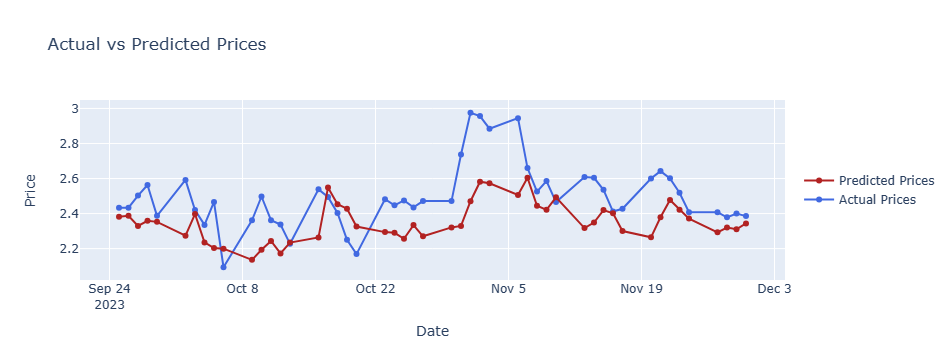

In [630]:
# Plotting
dates_for_plotting = test_data_2023_second_half.index[window_size:]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates_for_plotting, y=actuals,
                         mode='lines+markers',
                         name='Actual Prices',
                         line=dict(color='royalblue')))
fig.add_trace(go.Scatter(x=dates_for_plotting, y=predictions,
                         mode='lines+markers',
                         name='Predicted Prices',
                         line=dict(color='firebrick')))
fig.update_layout(title='Actual vs Predicted Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(y=0.5, traceorder='reversed', font_size=12))

fig.show()

### Post LASSO New Linear 

In [631]:
# Pair feature names with their coefficients into a dictionary for easy handling
new_lasso_coefficients_dict = dict(zip(feature_names, new_lasso_combined_coefficients))

# Identify non-zero coefficients (features not dropped by Lasso)
new_non_zero_coefficients = {feature: coef for feature, coef in new_lasso_coefficients_dict.items() if abs(coef) >= 1e-10}

# Print features not reduced to zero by Lasso
print("Features retained by Lasso:")
for feature in new_non_zero_coefficients.keys():
    print(feature)

# Filter the original dataset to keep only features with non-zero coefficients
new_X_filtered = X[list(new_non_zero_coefficients.keys())]

Features retained by Lasso:
electricity_daily_average
ngtl_groundbirch_east_receipts_volume_(103m3)_in_GJ_lag1
lag_1
lag_3
lag_4


In [632]:
features_new = ['electricity_daily_average',
'ngtl_groundbirch_east_receipts_volume_(103m3)_in_GJ_lag1',
'lag_1',
'lag_3',
'lag_4']

In [633]:
# Preparing the features (X) and target (y)
X = training_data[features_new]
y = training_data[target]

# Linear Regression model pipeline
linear_model_pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=100)

# Cross-validation using TimeSeriesSplit for both scoring metrics
new_linear_cv_scores = cross_val_score(linear_model_pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Evaluation
new_linear_cv_scores_mean = -new_linear_cv_scores.mean()
new_linear_cv_scores_std = new_linear_cv_scores.std()
new_linear_rmse = np.sqrt(new_linear_cv_scores_mean)

(new_linear_cv_scores_mean, new_linear_cv_scores_std, new_linear_rmse)

(0.23292798722533092, 0.516116318551576, 0.4826261360777418)

In [634]:
# Rolling Window Approach
window_size = 60 

# Store predictions and actual values
predictions = []
actuals = []

# Loop over the test set, using a rolling window approach
for i in range(window_size, len(test_data_2023_second_half)):
    # Define the rolling window
    train_rolling = training_data.iloc[-window_size+i-len(test_data_2023_second_half):i-len(test_data_2023_second_half)]
    test_point = test_data_2023_second_half.iloc[i-window_size:i-window_size+1]
    
    # Prepare the features and target
    X_train_rolling = train_rolling[features_new]
    y_train_rolling = train_rolling[target]
    X_test_point = test_point[features_new]
    
    # Fit the model
    linear_model_pipeline.fit(X_train_rolling, y_train_rolling)
    
    # Make a prediction for the next point
    prediction = linear_model_pipeline.predict(X_test_point)
    
    # Store the prediction and actual value
    predictions.append(prediction[0])
    actuals.append(test_point[target].values[0])

# Calculate evaluation metrics
new_mse_lr = mean_squared_error(actuals, predictions)
new_rmse_lr = np.sqrt(new_mse_lr)
print(f"MSE: {new_mse_lr}, RMSE: {new_rmse_lr}")

MSE: 0.0201191287020786, RMSE: 0.1418419144755125


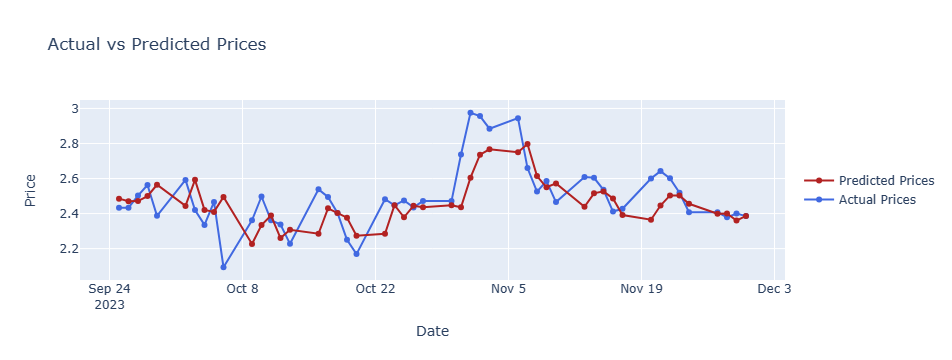

In [635]:
# Ensure the length of the datetime index matches the length of your predictions and actuals
dates_for_plotting = test_data_2023_second_half.index[window_size:]

# Create a Plotly figure
fig = go.Figure()

# Add actual prices to the plot
fig.add_trace(go.Scatter(x=dates_for_plotting, y=actuals,
                         mode='lines+markers',
                         name='Actual Prices',
                         line=dict(color='royalblue')))

# Add predicted prices to the plot
fig.add_trace(go.Scatter(x=dates_for_plotting, y=predictions,
                         mode='lines+markers',
                         name='Predicted Prices',
                         line=dict(color='firebrick')))

# Update layout
fig.update_layout(title='Actual vs Predicted Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(y=0.5, traceorder='reversed', font_size=12))

# Show the figure
fig.show()

In [636]:
# Creating a dataframe to compare the models' performance
model_comparison_df4 = pd.DataFrame({
    'Final Prediction Models': ['ARIMA', 'New LASSO', 'New Linear Regression'],
    'Average Mean Sqaured Error': [mse_arima, new_mse_lasso, new_mse_lr],
    'Average Root Mean Sqaured Error': [rmse_arima, new_rmse_lasso, new_rmse_lr]
})

model_comparison_df4

,Final Prediction Models,Average Mean Sqaured Error,Average Root Mean Sqaured Error
0,ARIMA,0.048443,0.220097
1,New LASSO,0.042342,0.205773
2,New Linear Regression,0.020119,0.141842
